In [1]:
import numpy as np
from numpy.random import normal
import pandas as pd
import copy
import matplotlib.pyplot as plt
from scipy.stats import norm
from itertools import repeat

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Load and clean data

## State names and abbreviation

Names of U.S. jurisdictions (states) and their abbreviation are organized into a DataFrame. The abbreviation will be used as geological labels for visualize data in the form of a map. District of Columbia is deleted and FED is added as abbreviation for Federal because DC is underneath the Federal jurisdiction.

In [2]:
states = pd.read_excel("./messy_data/states.xlsx")
states.drop(states.index[states.Abbreviation == "DC"], inplace=True)
states.columns = ["Jurisdiction", "Jurisdiction Abbreviation"]
states = states.append({"Jurisdiction" : "Federal", "Jurisdiction Abbreviation" : "FED"}, ignore_index=True)

In [3]:
states.head()

,Jurisdiction,Jurisdiction Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


## Prisoner population data

The U.S. Bureau of Justice Statistics surveys the inmates annually and publishes the _Prisoners In XXXX_ series, reporting the demographics of the U.S. prisoner population. They congregate the data in both federal and states’ male and female prison system. The data table is then melted to an analysis-ready and clean format with rows representing observation while columns indicates variables.

In [4]:
malePrisonerPopulation = pd.read_excel("./messy_data/Prisoners under the jurisdiction of state or federal correctional authorities 1978-2016.xlsx", sheet_name="Male", header=9, nrows=54).dropna(1, "all").dropna(0)
malePrisonerPopulation.head()

,Jurisdiction,1978,1979,1980,1981,1982,1983,1984,1985,1986,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
1,Federal,27975.0,24835.0,22964.0,26574.0,28046.0,30172.0,32267.0,37819.0,41575.0,...,186280,188007,194493,196222,202462,203766,201697,196568,183502,176495
3,Alabama,5368.0,5221.0,6278.0,7339.0,8757.0,9375.0,9961.0,10453.0,11094.0,...,27254,28277,29419,29261,29696,29782,29660,29182,28220,26506
4,Alaska,678.0,729.0,801.0,977.0,1276.0,1557.0,1888.0,2207.0,2344.0,...,4603,4511,4696,4782,4932,4934,4450,5091,4761,4024
5,Arizona,3275.0,3573.0,4153.0,4986.0,5788.0,6566.0,7482.0,8134.0,8948.0,...,34286,35739,36768,36521,36470,36447,37402,38295,38738,38323
6,Arkansas,2553.0,2927.0,2805.0,3197.0,3755.0,4050.0,4286.0,4394.0,4477.0,...,13248,13656,14147,15040,14995,13594,15904,16476,16305,16161


In [5]:
def cleanPopulationTable(table, states):
    
    # add DC data to Federal, and delete it
    table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] = table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] + table.loc[table.Jurisdiction == "District of Columbia"].iloc[:, 1:].replace("--", 0)
    table.drop(table.index[table.Jurisdiction == "District of Columbia"], inplace=True)
    
    table = states.merge(table, on="Jurisdiction")
    
    return table

Originally, District of Columbia was treated as an independent jurisdiction in Bureau of Justice Statistics's survey. However, as of 2001, it is being considered as part of the federal jurisdiction. This created some missing values for the District of Columbia data and the federal data starting in 2001. To correct for the inconsistency, the District of Comubia data prior to 2001 is added into the federal prisoner population during data cleaning.

In [6]:
malePrisonerPopulation = cleanPopulationTable(malePrisonerPopulation, states)
malePrisonerPopulation.head()

/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Jurisdiction,Jurisdiction Abbreviation,1978,1979,1980,1981,1982,1983,1984,1985,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Alabama,AL,5368.0,5221.0,6278.0,7339.0,8757.0,9375.0,9961.0,10453.0,...,27254,28277,29419,29261,29696,29782,29660,29182,28220,26506
1,Alaska,AK,678.0,729.0,801.0,977.0,1276.0,1557.0,1888.0,2207.0,...,4603,4511,4696,4782,4932,4934,4450,5091,4761,4024
2,Arizona,AZ,3275.0,3573.0,4153.0,4986.0,5788.0,6566.0,7482.0,8134.0,...,34286,35739,36768,36521,36470,36447,37402,38295,38738,38323
3,Arkansas,AR,2553.0,2927.0,2805.0,3197.0,3755.0,4050.0,4286.0,4394.0,...,13248,13656,14147,15040,14995,13594,15904,16476,16305,16161
4,California,CA,20178.0,21400.0,23253.0,27775.0,32987.0,37353.0,40892.0,47248.0,...,162654,162050,160286,155104,141382,128436,129684,129703,123808,124487


## Admission and release data

The U.S. Bureau of Justice Statistics also surveys the statistics about annual admission and release in each jurisdiction. These data are very important in terms of building a model that accounts for the temporal dynamics of the prisoner population.

In [7]:
maleAdmission = pd.read_excel("./messy_data/admissions.xlsx", sheet_name="Male").dropna().replace("/", np.nan)
maleRelease = pd.read_excel("./messy_data/releases.xlsx", sheet_name="Male").dropna().replace("/", np.nan)

In [8]:
def cleanCountTable(table, states):
    
    # add DC data to Federal, and delete it
    table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] = table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] + table.loc[table.Jurisdiction == "District of Columbia"].iloc[:, 1:].replace("--", 0)
    table.drop(table.index[table.Jurisdiction == "District of Columbia"], inplace=True)
    
    table = states.merge(table, on="Jurisdiction")
    
    return table

The inconsistency that involves the District of Columbia and federal numbers, as pointed out for the population data above, also exists for the annual admission and release data. It is corrected in the same fashion as mentioned before.

In [9]:
maleAdmission = cleanCountTable(maleAdmission, states)
maleRelease = cleanCountTable(maleRelease, states)

In [10]:
maleAdmission.head()

,Jurisdiction,Jurisdiction Abbreviation,1978,1979,1980,1981,1982,1983,1984,1985,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Alabama,AL,2404.0,2382.0,3576.0,3773.0,4121.0,4283.0,4342.0,4013.0,...,9384,9683,11429,10341,9919,9683,9683,9391,8888,9155
1,Alaska,AK,250.0,303.0,449.0,430.0,502.0,681.0,697.0,840.0,...,NaN,NaN,NaN,2287,3090,3199,3199,3145,3131,1502
2,Arizona,AZ,1504.0,1559.0,1935.0,2594.0,2730.0,3088.0,3193.0,3755.0,...,12369,13129,12883,11708,11576,11486,12069,12747,12994,11933
3,Arkansas,AR,1851.0,2079.0,2192.0,2305.0,2182.0,2027.0,2034.0,2110.0,...,5938,6267,6596,6797,6346,5181,7939,8314,8112,8549
4,California,CA,11263.0,14245.0,13558.0,16835.0,20744.0,25195.0,26858.0,34620.0,...,125814,126768,117136,108157,88702,32103,35562,36025,32474,33232


In [11]:
maleRelease.head()

,Jurisdiction,Jurisdiction Abbreviation,1978,1979,1980,1981,1982,1983,1984,1985,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Alabama,AL,2568.0,2519.0,3008.0,2677.0,2639.0,2923.0,3527.0,3377.0,...,9679,10128,10730,10572,9629,9794,9983,9928,9901,10895
1,Alaska,AK,229.0,208.0,248.0,258.0,324.0,484.0,473.0,593.0,...,2824,3183,2707,2645,2953,3080,3080,3080,2966,1826
2,Arizona,AZ,1220.0,1510.0,1353.0,1733.0,1879.0,2096.0,2344.0,3130.0,...,11202,11655,12279,11944,11589,11580,11507,11973,12497,12197
3,Arkansas,AR,1772.0,1771.0,2229.0,1946.0,1618.0,1765.0,1801.0,1987.0,...,5357,5854,6203,5952,6468,5646,5752,7759,8427,8943
4,California,CA,9194.0,12647.0,11574.0,12180.0,14998.0,20743.0,23279.0,27936.0,...,122328,123585,115944,110464,100001,43413,33996,35922,38322,32199


## Annual sentencing data

The U.S. Sentencing Commission is an independent agency of the judicial branch of the federal government. It composes the sentencing guidelines for the U.S. federal courts. It also publishes annual statistics pertaining to the criminal case sentencing. They survey the average national sentencing every year.

In [12]:
anualSentence = pd.read_excel("./messy_data/national sentencing.xlsx").iloc[:, [0,1]]
anualSentence.columns = ["Year", "Sentence"]
anualSentence.set_index("Year", inplace=True)
anualSentence = anualSentence.iloc[:-1,0]

Text(0.5, 1.0, 'National Average Sentencing')

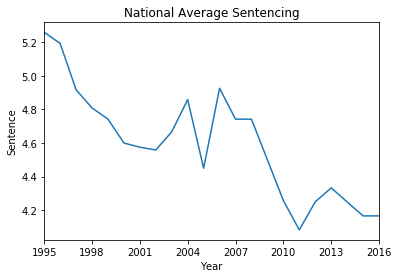

In [13]:
anualSentence.plot()
plt.xticks(np.array(range(1995, 2017, 3)))
plt.ylabel("Sentence")
plt.title("National Average Sentencing")

It seems that at the national level, sentences are getting shorter. However, it is difficult to justify building a model that is centered around the idea of a more lenient justice system in the long run because only a limited number of data points are available, making it impossibe to distinguish whether this trend is merely a short-term adjustment or a sustained effect. Thus, a normal distribution is adopted to sample future sentences.

# Model

Using federal data to demonstrate a model:

In [14]:
def extractStatePopulationCount(table, jurisdiction, tableType, year_begin=1978,year_end=2016):
    
    jurisdictions = table.Jurisdiction
    data = table.loc[jurisdictions==jurisdiction].iloc[0, 2:].astype(float)
    data = data.interpolate() # linear interpolation to fill in missing data
    data = data[np.logical_and(data.index <= year_end, data.index >= year_begin)]
    data.name = tableType
    data.index.name="Year"
    
    return data

(Note: some jurisdiction also failed to report their data during certain years. The corresponding missing values are interpolated linearly.)

In [15]:
jurisdiction = "Federal"

population = extractStatePopulationCount(malePrisonerPopulation, jurisdiction, "Population")
admission = extractStatePopulationCount(maleAdmission, jurisdiction, "Admission")
release = extractStatePopulationCount(maleRelease, jurisdiction, "Release")

Text(0.5, 1.0, 'Prisoner Population Dynamics, Federal')

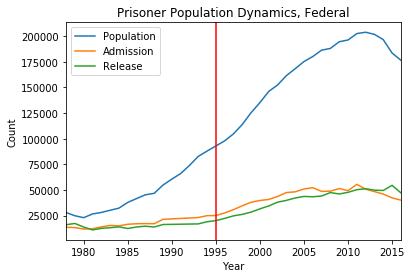

In [16]:
population.plot()
admission.plot()
release.plot()
plt.axvline(1995, color="red")
plt.legend()
plt.ylabel("Count")
plt.title("Prisoner Population Dynamics, Federal")

Given data of annual population $p[t]$, admission $a[t]$ and release $r[t]$, we can model the yearly dynamics of prisoner population with a first degree difference stochastic process
$$p[t] - p[t - 1] = a[t] - r[t] + \varepsilon p[t - 1], \varepsilon  \sim N(0,\delta^2 )$$
where $\varepsilon p[t - 1]$ is the Gaussian error term and $\varepsilon$ indicates the error is proportional to the previous population. $\varepsilon$ should be zero-centered with a variance of $\delta^2$. Given past anual survey of the prisoner population, admission and release, the equation above can be used to estimate the variance of $\varepsilon$.

In [17]:
epsilon = (population.diff() - admission + release).values[1:] / population.values[:-1]

/anaconda3/envs/SpringBoard/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Proportional, Federal')

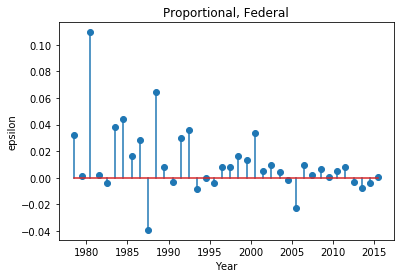

In [18]:
plt.stem(np.array(range(1979, 2017)) - 0.5, epsilon)
plt.xlabel("Year")
plt.ylabel("epsilon")
plt.title("Proportional, Federal")

In [19]:
epsilon_sd = epsilon.std()
epsilon_sd

0.02460665543654828

Every year it is assumed that any prisoner's remaining sentence to serve is also a random variable $s[t]$ which is normally distributed. The center of that distribution is year-dependent and denoted $\mu [t]$, while the variance $\sigma^2$ is assumed to be invariate. The annual release can be approximated with such distribution's cumulative distribution function
$$r[t] = F(1;\mu [t - 1],{\sigma ^2})p[t - 1]$$
$F(1)$ represents the proportion of prisoners whose remaining sentence is less than 1 year.

A second degree difference equation is used to describe the temporal evolution of the combined remaining sentence  of the whole prisoner body
$$p[t]\mu [t] = p[t - 1](\mu [t - 1] - 1) + 0.5r[t] + a[t]y[t] - 0.5a[t]$$
$p[t - 1](\mu [t - 1] - 1)$ represents the previous year's population's average number of remaining years to serve reduces by 1 year. However, because $r[t]$ prisoners are being released, 1 year of decrease is an over-estimation. On average, for each prisoner released, a half-year over-estimation is introduced. Thus, it is compensated by the $+0.5r[t]$ term given the prisoners are released evenly throughout the year. $y[t]$ is the average sentence of the admitted prisoner of that year. $a[t]y[t]$ represents the contribution of the newly admitted prisoners. Similarly, for each newly admitted prisoner, because the individual will have served some time by the end of the year, we introduced a half-year over-estimation, which is corrected by the $-0.5a[t]$ term.

Provided the annual average sentence of the newly admitted prisoners and the initial state of $\mu [t]$ ($\mu [1994]$ due to the lack of anual sentencing data prior to 1995), equation $p[t]\mu [t] = p[t - 1](\mu [t - 1] - 1) + 0.5r[t] + a[t]y[t] - 0.5a[t]$ can be used to propagate the state of the system and resolve $\mu [t]$.

In [20]:
modernPopulation = extractStatePopulationCount(malePrisonerPopulation, jurisdiction, "Population", 1995,2016)
modernAdmission = extractStatePopulationCount(maleAdmission, jurisdiction, "Admission", 1995,2016)
modernRelease = extractStatePopulationCount(maleRelease, jurisdiction, "Release", 1995,2016)

In [21]:
def extractInitialPopulation(table, jurisdiction):
    
    jurisdictions = table.Jurisdiction
    population = table.loc[jurisdictions==jurisdiction].iloc[0, 2:].astype(float)
    population = population.interpolate() # linear interpolation to fill in missing data
    initialPopulation = population[population.index == 1994]
    initialPopulation.name = "Population"
    initialPopulation.index.name="Year"
    
    return initialPopulation

Here, an initial state of $\mu[1994] = 20$ is used.

In [22]:
initialPopulation = extractInitialPopulation(malePrisonerPopulation, jurisdiction)
initialPopulation

Year
1994    87894.0
Name: Population, dtype: float64

In [23]:
initialMu = 20

In [24]:
def propagateMu(past_mu,past_p, current_p, current_a,current_r, current_y):
    # State propagation function
    return (past_p * (past_mu - 1) + 0.5 * current_r + current_a * current_y - 0.5 * current_a) / current_p


In [25]:
def solveMu(initialMu,initialPopulation, population, admission,release, anualSentence):
    # Given the initial state of mu and populatin,
    # this function can calculate the evolution of mu
    # according to the revolution of population, admission, release, and average sentence
    
    mu = population * 0
    mu.name = "Mu"

    
    for i, p in enumerate(population):
    
        if i == 0:
            past_p = initialPopulation.values
            past_mu = initialMu

        mu.iloc[i] = propagateMu(past_mu, past_p, population.iloc[i], admission.iloc[i],release.iloc[i], anualSentence.iloc[i])
        
        past_mu = mu.iloc[i]
        past_p = population.iloc[i]
        
    mu[1994] = initialMu
    mu.sort_index(inplace=True)
    
    return mu

In [26]:
mu = solveMu(initialMu,initialPopulation, modernPopulation, modernAdmission,modernRelease, anualSentence)

Text(0.5, 1.0, 'Average Remaining Sentence, Federal')

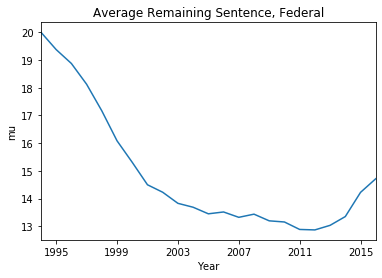

In [27]:
mu.plot()
plt.xticks(np.array(range(1995, 2016, 4)))
plt.ylabel("mu")
plt.title("Average Remaining Sentence, Federal")

Using the resolved $\mu[t]$ and the relationship of $r[t] = F(1;\mu [t - 1],{\sigma ^2})p[t - 1]$, for each year, a $\sigma$ is calculated. The average is taken for a point estimate.

In [28]:
modernPopulation = pd.concat((initialPopulation, modernPopulation))

In [29]:
def estimateSigmaOfNormalCDF(x,F, mu):
    # This function can take vetor input
    
    # we have function F(x) as the CDF of N(mu, sigma^2)
    # given function Phi(x) as the CDF of N(0, 1)
    # F(x) = Phi((x - mu) / sigma)
    
    # the reverse function of Phi is norm.ppf()
    
    return (x - mu) / norm.ppf(F) 
    

In [30]:
def estimateSigma(population, release, mu):
    
    mu = mu.values[: -1]
    p = population.values[: -1]
    r = release.values

    
    F = r / p
    sigma = estimateSigmaOfNormalCDF(1,F, mu)
    sigma = sigma[sigma >= 0]
    
    return sigma.mean()

In [31]:
sigma = estimateSigma(modernPopulation, modernRelease, mu)
print("sigma: " + str(sigma))

sigma: 20.738450343381512


# Forecast

## Simulation of one future trajectory

The annual admission and the average sentence can be sampled by building a normal distribution where the variance comes from estimation via past data, while the center is the last-reported data point (2016).

In [32]:
admissionSD = modernAdmission.std()
sentenceSD = anualSentence.std()

First, simulate the anual admission and average sentence.

In [33]:
def sampleFutureAdmissionSentence(sampleMean,sampleSD, year_end, dataType):
    
    years = range(2017, year_end + 1)
    simulated = normal(sampleMean,sampleSD, len(years))
    simulated[simulated <= 0] = sampleMean
    if dataType == "Admission":
        simulated = np.round(simulated)
    
    simulated = pd.Series(simulated, index=years, name=dataType, dtype=int)
    simulated.index.name = "Year"
    
    return simulated

In [34]:
futureAdmission = sampleFutureAdmissionSentence(modernAdmission.iloc[-1],admissionSD, 2050, "Admission")
futureSentence = sampleFutureAdmissionSentence(anualSentence.iloc[-1],sentenceSD, 2050, "Sentence")

Second, given $\mu[t-1]$ and $\sigma$, we can determine the current year's release by the former year's population using $r[t] = F(1;\mu [t - 1],{\sigma ^2})p[t - 1]$. Equation $p[t] - p[t - 1] = a[t] - r[t] + \varepsilon p[t - 1]$ can then be used to sample for the following year's prisoner population. Finally, equation $p[t]\mu [t] = p[t - 1](\mu [t - 1] - 1) + 0.5r[t] + a[t]y[t] - 0.5a[t]$ can determine current year's $\mu$. In this fashion, one full iteration of state evolution is completed.

In [35]:
def propagateState(past_mu,past_p, current_a,current_y, epsilon_sd, sigma):
    
    if np.isnan(sigma):
        current_r = (- past_p + current_a * (current_y - 0.5 + past_mu)) / (past_mu - 0.5)
        # Such dynamic stablizes mu
    else:
        current_r = np.round(norm(past_mu, sigma).cdf(1) * past_p)
    current_p = np.round(past_p + current_a - current_r + normal(scale=epsilon_sd) * past_p)
    current_mu = propagateMu(past_mu,past_p, current_p, current_a,current_r, current_y)
    
    return current_mu, current_p, current_r
    

In [36]:
initialMu = mu.iloc[-1]
initialPopulation = modernPopulation.iloc[-1]

In [37]:
def solvePopulation(initialMu,initialPopulation, futureAdmission,futureSentence, epsilon_sd, sigma):
    
    futurePopulation = futureAdmission * 0
    futurePopulation.name = "Population"
    
    futureRelease = futureAdmission * 0
    futureRelease.name = "Release"
    
    futureMu = futureSentence *0
    futureMu.name = "Mu"
    
    for i, p in enumerate(futurePopulation):
        
        if i == 0:
            past_mu = initialMu
            past_p = initialPopulation
            
        futureMu.iloc[i], futurePopulation.iloc[i], futureRelease.iloc[i] = propagateState(past_mu,past_p, futureAdmission.iloc[i],futureSentence.iloc[i], epsilon_sd, sigma)
        
        past_mu = futureMu.iloc[i]
        past_p = futurePopulation.iloc[i]
        
    return futureMu, futurePopulation, futureRelease

In [38]:
futureMu, futurePopulation, futureRelease = solvePopulation(initialMu,initialPopulation, futureAdmission,futureSentence, epsilon_sd, sigma)

Text(0.5, 1.0, 'Prisoner Population Projection, Federal')

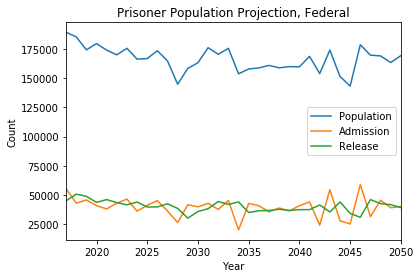

In [39]:
futurePopulation.plot()
futureAdmission.plot()
futureRelease.plot()
plt.legend()
plt.ylabel("Count")
plt.title("Prisoner Population Projection, Federal")

Text(0.5, 1.0, 'Average Remaining Sentence Projection, Federal')

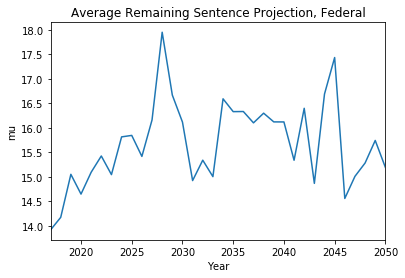

In [40]:
futureMu.plot()
plt.ylabel("mu")
plt.title("Average Remaining Sentence Projection, Federal")

## Simulate and average a group of trajectories

1000 simulations generate the mean and standard deviation of the projectjion. Shaded area represents MEAN ± SD.

In [41]:
futureAdmissions = [sampleFutureAdmissionSentence(modernAdmission.iloc[-1],admissionSD, 2050, "Admission") for i in range(1000)]
futureSentences = [sampleFutureAdmissionSentence(anualSentence.iloc[-1],sentenceSD, 2050, "Sentence") for i in range(1000)]

futureMus, futurePopulations, futureReleases = zip(*map(solvePopulation, repeat(initialMu),repeat(initialPopulation), futureAdmissions,futureSentences, repeat(epsilon_sd), repeat(sigma)))

Text(0.5, 1.0, 'Average Remaining Sentence Projection, Federal')

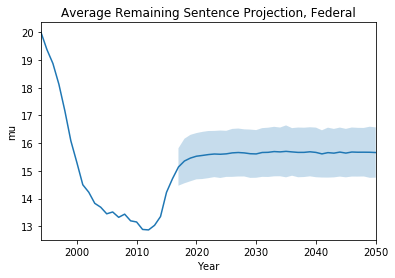

In [42]:
futureMu_mean = pd.concat(futureMus, axis=1).mean(axis=1)
futureMu_sd = pd.concat(futureMus, axis=1).std(axis=1)

pd.concat([mu, futureMu_mean]).plot()
plt.fill_between(futureMu_mean.index, futureMu_mean-futureMu_sd, futureMu_mean+futureMu_sd, alpha=0.25)
plt.ylabel("mu")
plt.title("Average Remaining Sentence Projection, Federal")

In [43]:
futurePopulation_mean = pd.concat(futurePopulations, axis=1).mean(axis=1)
futurePopulation_mean.name = "Population"

futurePopulation_sd = pd.concat(futurePopulations, axis=1).std(axis=1)

In [44]:
futureAdmission_mean = pd.concat(futureAdmissions, axis=1).mean(axis=1)
futureAdmission_mean.name = "Admission"

futureAdmission_sd = pd.concat(futureAdmissions, axis=1).std(axis=1)

In [45]:
futureRelease_mean = pd.concat(futureReleases, axis=1).mean(axis=1)
futureRelease_mean.name = "Release"

futureRelease_sd = pd.concat(futureReleases, axis=1).std(axis=1)

Text(0.5, 1.0, 'Prisoner Population Projection, Federal')

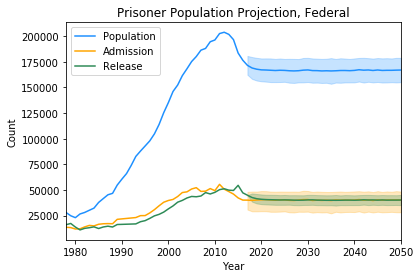

In [46]:
pd.concat([population, futurePopulation_mean]).plot(color="dodgerblue")
plt.fill_between(futurePopulation_mean.index, futurePopulation_mean - futurePopulation_sd, futurePopulation_mean + futurePopulation_sd, color="dodgerblue", alpha=0.25)

pd.concat([admission, futureAdmission_mean]).plot(color="orange")
plt.fill_between(futureAdmission_mean.index, futureAdmission_mean - futurePopulation_sd, futureAdmission_mean + futureAdmission_sd, color="orange", alpha=0.25)

pd.concat([release, futureRelease_mean]).plot(color="seagreen")
plt.fill_between(futureRelease_mean.index, futureRelease_mean - futureRelease_sd, futureRelease_mean + futureRelease_sd, color="seagreen", alpha=0.25)

plt.legend()
plt.ylabel("Count")
plt.title("Prisoner Population Projection, Federal")